# Terminology-Aware Analytics with FHIR

The purpose of this exercise is to demonstrate a workflow for sourcing clinical data from [FHIR](https://hl7.org/fhir) resources for the purposes of doing some exploratory data analysis and data engineering in preparation for some downstream data science.

In [1]:
from pyspark.sql import SparkSession
import http.client
from plotnine import *

spark = SparkSession.builder.appName("tx-analytics-fhir").getOrCreate()
tx_conn = http.client.HTTPConnection('ontoserver', 8080)
headers = {
  'Accept': 'application/fhir+json',
  'Content-Type': 'application/fhir+json'
}

theme_set(theme_light() + 
          theme(legend_key_size=8, 
                axis_title_x=element_text(margin={'t': 15}), 
                axis_title_y=element_text(margin={'r': 15}), 
                legend_title=element_text(margin={'b': 15})))

## Data preparation

We start with a [Synthea](https://synthetichealth.github.io/synthea/) dataset of 1,185 patients, which is a set of FHIR [Bundles](https://www.hl7.org/fhir/bundle.html). Each Bundle contains the longitudinal record for a synthetic patient, containing a variety of FHIR resources that represent different events and aspects of their clinical record throughout their life.

For the purposes of this exercise, we are only interested in the [Patient](https://www.hl7.org/fhir/patient.html), [Observation](http://hl7.org/fhir/STU3/observation.html) and [Condition](https://www.hl7.org/fhir/condition.html) resources. The following code extracts these resource types from each bundle into its own [Spark](https://spark.apache.org/) Dataset.

In [2]:
warehouse_location = 'file:///usr/share/warehouse/default'

patients = spark.read.parquet(warehouse_location + '/' + 'Patient.parquet').cache()
observations = spark.read.parquet(warehouse_location + '/' + 'Observation.parquet').cache()
conditions = spark.read.parquet(warehouse_location + '/' + 'Condition.parquet').cache()

We now have a Spark dataset available within our cluster for querying for each of our resources. We can query and summarise these Datasets using the cluster, and bring them into local Pandas DataFrames at our convenience.

## Basic demographics

Let's have a quick look at the demographic profile of our synthetic patient population.

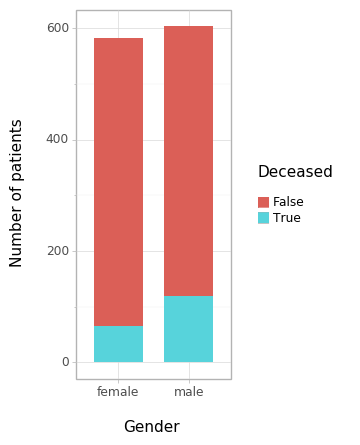

<ggplot: (-9223363254552004583)>

In [3]:
from pyspark.sql.functions import count

dems_dataset = patients.select(patients.gender, patients.birthDate, patients.deceasedDateTime.isNotNull().alias('deceased'))
dems = dems_dataset.toPandas()

dem_counts = dems_dataset.groupBy(patients.gender, dems_dataset.deceased) \
                         .agg(count('*').alias('count')) \
                         .orderBy(patients.gender, dems_dataset.deceased)

ggplot(dems) + aes(x='gender', fill='deceased') \
             + geom_bar(width=0.7) \
             + scale_x_discrete(name='Gender') \
             + scale_y_continuous(name='Number of patients') \
             + scale_fill_discrete(name='Deceased') \
             + theme(figure_size=(2,4.8))

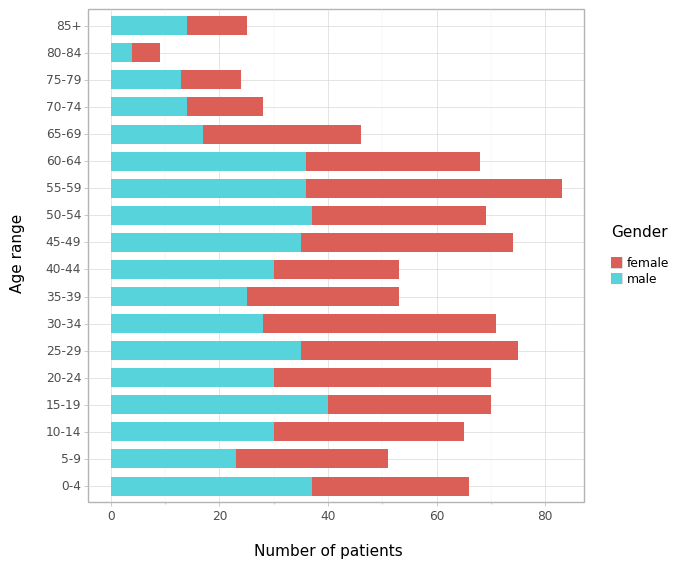

<ggplot: (-9223363254544034286)>

In [4]:
import pandas as pd
import numpy as np
import math

# Select gender and birth date for alive patients.
dems = patients.select(patients.gender, patients.birthDate) \
               .where(patients.deceasedDateTime.isNull()) \
               .toPandas()
        
# Make gender 'categorical'.
dems.gender = dems.gender.astype('category')

# Convert birth date into a Pandas date/time.
dems.birthDate = pd.to_datetime(dems.birthDate, format='%Y-%m-%d')

# Map birth dates to age in years.
dems['age'] = dems.birthDate.map(lambda bd: math.floor((pd.Timestamp('now') - bd) / np.timedelta64(1, 'Y')))

# Bucketize ages.
dems['ageRange'] = pd.cut(dems.age, 
                          bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,  85, 300], 
                          labels=['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', 
                                  '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+'],
                          include_lowest=True)

# Create a stacked bar chart.
ggplot(dems) + aes(x='ageRange', fill='gender') \
             + geom_bar(width=0.7) \
             + scale_x_discrete(name='Age range') \
             + scale_y_continuous(name='Number of patients') \
             + scale_fill_discrete(name='Gender') \
             + coord_flip() \
             + theme(figure_size=(6.4,6.4))

TODO: Create "Deaceased" as a category within the second plot, and remove the first?

## Disease profile

Next we will build up a picture of the types of diseases that are active within the population at a nominated point in time.

First we need to create a new dataset, which joins the Patient and Condition resources. As part of our join condition, we will require that the condition is active on June 1, 2019, which we will check using the values of the `onset` and `abatement` elements.

In [5]:
from pyspark.sql.functions import expr, explode_outer, countDistinct

report_date = '2019-06-01'

conditions_dataset = patients.join(conditions, (patients.id == conditions.subject.reference) & \
                                   # We allow for the onset to be empty, and assume that this means the condition was active back to birth.
                                   (conditions.onsetDateTime.isNull() | expr("onsetDateTime <= \"%s\"" % report_date)) & \
                                   # We allow for the abatement to be empty, and assume that this means the condition was active until
                                   # death or the end of the simulation.
                                   (conditions.abatementDateTime.isNull() | expr("abatementDateTime >= \"%s\"" % report_date)),
                                   'left_outer') \
                             .select(patients.id, explode_outer(conditions.code.coding).alias('conditionCoding'))

# Count the distinct condition codes.
conditions_dataset.agg(countDistinct(conditions_dataset.conditionCoding).alias('Number of distinct condition codes')) \
                  .toPandas()

,Number of distinct condition codes
0,106


Now we can take a look at which conditions are most prevalent in our population. Note that these are not mutually-exclusive categories - one patient could have more than one of these conditions.

In [6]:
from pyspark.sql.functions import col

top_10 = conditions_dataset.groupBy(conditions_dataset.conditionCoding.code.alias('Condition code'), \
                                    conditions_dataset.conditionCoding.display.alias('Name of condition')) \
                           .agg(countDistinct(patients.id).alias('Number of patients')) \
                           .orderBy(col('Number of patients').desc()) \
                           .limit(10)
top_10.toPandas()

,Condition code,Name of condition,Number of patients
0,162864005,Body mass index 30+ - obesity (finding),365
1,15777000,Prediabetes,351
2,271737000,Anemia (disorder),339
3,59621000,Hypertension,324
4,None,None,260
5,40055000,Chronic sinusitis (disorder),242
6,19169002,Miscarriage in first trimester,203
7,55822004,Hyperlipidemia,134
8,44054006,Diabetes,98
9,302870006,Hypertriglyceridemia (disorder),95


## Disease grouping

As there is a subsumption hierarchy within SNOMED CT, we can simply walk up the tree to get more generalised concepts. The appropriate grouping concepts will differ for each use case. Tools like Shrimp can help you select the best groupers by allowing you to visualise the hierarchy that exists further up from a given concept.

For this exercise, we are going to create a grouping category that captures our number 2 most prevalent condition: Prediabetes. We will create a broader grouping using the "Disorder of glucose regulation" concept within SNOMED CT, which will also capture other conditions like hyperinsulinism.

TODO: Show different ways of representing this ValueSet in FHIR.

In [7]:
valueset = {
  "resourceType": "ValueSet",
  "compose": {
    "include": [
      {
        "system": "http://snomed.info/sct",
        "filter": [
          {
            "property": "constraint",
            "op": "=",
            "value": "<< 237597000|Disorder of glucose regulation|"
          }
        ]
      }
    ]
  }
}

We can then use this ValueSet to query the codes from a [FHIR terminology server](https://www.hl7.org/fhir/terminology-service.html). This returns a set of 115 codes.

In [8]:
import json
from pyspark.sql import Row

tx_conn.request('POST', '/fhir/ValueSet/$expand', json.dumps(valueset),
                headers=headers)
response = tx_conn.getresponse()
json_string = response.read()
parsed = json.loads(json_string)

codes = [Row(system=x['system'], code=x['code']) for x in parsed['expansion']['contains']]
valueset_codes = spark.createDataFrame(codes, ['code', 'system'])

valueset_codes.toPandas()

,code,system
0,237642002,http://snomed.info/sct
1,199225007,http://snomed.info/sct
2,111558006,http://snomed.info/sct
3,721236002,http://snomed.info/sct
4,773666007,http://snomed.info/sct
...,...,...
110,237625008,http://snomed.info/sct
111,237598005,http://snomed.info/sct
112,302866003,http://snomed.info/sct
113,128264007,http://snomed.info/sct


Now we can have a look at our top 10, and see how many of them are members of our new ValueSet.

In [9]:
top_10_membership = top_10.join(valueset_codes, top_10['Condition code'] == valueset_codes.code, 'left_outer') \
                          .select(top_10['Condition code'], top_10['Name of condition'], 
                                  top_10['Number of patients'], valueset_codes.code.isNotNull().alias('In one of our groupings?'))
top_10_membership.toPandas()

,Condition code,Name of condition,Number of patients,In one of our groupings?
0,162864005,Body mass index 30+ - obesity (finding),365,False
1,None,None,260,False
2,59621000,Hypertension,324,False
3,40055000,Chronic sinusitis (disorder),242,False
4,15777000,Prediabetes,351,False
5,271737000,Anemia (disorder),339,False
6,55822004,Hyperlipidemia,134,False
7,19169002,Miscarriage in first trimester,203,False
8,302870006,Hypertriglyceridemia (disorder),95,False
9,44054006,Diabetes,98,False


None of them are captured! If we look up Prediabetes in Shrimp, we will discover why - this concept is inactive within the current release of SNOMED CT.

## Historical codes

#### Historical codes

Most real clinical datasets include data that has been captured over a long period of time. This brings with it the challenges of dealing with codes which were valid at the time of capture, but have since been retired in subsequent terminology releases.

In order to accurately label our patients using our disease groupings, we need to look for not just codes that are currently active within SNOMED CT, but also codes which have since been retired and replaced by newer codes. Luckily, SNOMED CT retains this information within the terminology through its [historical association relationships](https://confluence.ihtsdotools.org/display/DOCRFSPG/3.2.6.3.2.+Representing+Historical+Associations).

Historical association relationships in SNOMED CT can be interrogated using a FHIR terminology server. [Implicit ConceptMaps](https://www.hl7.org/fhir/snomedct.html#implicit-cm) exist that can be used with the translate operation to retrieve the codes that we need.

In [10]:
snomed_uri = 'http://snomed.info/sct'

We're going to look at all the types of historical association maps, to cast our net as wide as possible in search of relevant codes.

In [11]:
association_maps = ['900000000000523009', '900000000000526001',
                    '900000000000527005', '900000000000530003']

We will submit all of the required translate requests to the FHIR server as a batch.

In [12]:
batch = {
  'resourceType': 'Bundle',
  'type': 'batch',
  'entry': []
}

Create a Bundle entry for each code in our ValueSet, for each association map.

In [13]:
for association_map in association_maps:
  for code in valueset_codes.collect():
    map_uri = snomed_uri + '?fhir_cm=' + association_map
    entry = {
      'request': {
        'method': 'POST',
        'url': 'ConceptMap/$translate'
      },
      'resource': {
        'resourceType': 'Parameters',
        'parameter': [
          {
            'name': 'url',
            'valueUri': map_uri
          },
          {
            'name': 'system',
            'valueUri': snomed_uri
          },
          {
            'name': 'code',
            'valueCode': code['code']
          },
          {
            'name': 'reverse',
            'valueBoolean': True
          }
        ]
      }
    }
    batch['entry'].append(entry)

Execute the batch request.

In [14]:
tx_conn.request('POST', '/fhir', json.dumps(batch), headers=headers)

response = tx_conn.getresponse()
json_string = response.read()
parsed = json.loads(json_string)

Get the Parameters response for each translation out of the response Bundle.

In [15]:
response_params = [x['resource'] for x in parsed['entry'] if
                   x['response']['status'] == '200' and x['resource'][
                     'resourceType'] == 'Parameters']

Takes the concept part from each match parameter within each result, then appends the code to the replaced_codes list.

In [16]:
replaced_codes = []
for parameters in response_params:
  replaced_codes += [[Row(code=y['valueCoding']['code']) for y in x['part'] if
                      y['name'] == 'concept'][0]
                     for x in parameters['parameter'] if x['name'] == 'match']

Add the additional codes to our ValueSet definition, as enumerated codes.

In [17]:
valueset['compose']['include'] \
  .append({'system': snomed_uri,
           'concept': [{'code': code} for code in replaced_codes]})

Now we can expand our ValueSet again, and see that we have captured the additional codes within the new expansion.

In [18]:
tx_conn.request('POST', '/fhir/ValueSet/$expand', json.dumps(valueset),
                headers=headers)
response = tx_conn.getresponse()
json_string = response.read()
parsed = json.loads(json_string)
codes = [Row(system=x['system'], code=x['code']) for x in parsed['expansion']['contains']]
valueset_codes = spark.createDataFrame(codes, ['code', 'system'])

valueset_codes.toPandas()

,code,system
0,190428000,http://snomed.info/sct
1,267476006,http://snomed.info/sct
2,154692004,http://snomed.info/sct
3,314772004,http://snomed.info/sct
4,421164006,http://snomed.info/sct
...,...,...
144,237625008,http://snomed.info/sct
145,237598005,http://snomed.info/sct
146,302866003,http://snomed.info/sct
147,128264007,http://snomed.info/sct


Excellent, we have successfully added an additional 34 historical codes to our ValueSet. Now we can have another look at our top 10, and see that Prediabetes is now successfully identified as a member of our ValueSet.

In [19]:
top_10_membership = top_10.join(valueset_codes, top_10['Condition code'] == valueset_codes.code, 'left_outer') \
                          .select(top_10['Condition code'], top_10['Name of condition'], 
                                  top_10['Number of patients'], valueset_codes.code.isNotNull().alias('In one of our groupings?'))
top_10_membership.toPandas()

,Condition code,Name of condition,Number of patients,In one of our groupings?
0,162864005,Body mass index 30+ - obesity (finding),365,False
1,None,None,260,False
2,59621000,Hypertension,324,False
3,40055000,Chronic sinusitis (disorder),242,False
4,15777000,Prediabetes,351,True
5,271737000,Anemia (disorder),339,False
6,55822004,Hyperlipidemia,134,False
7,19169002,Miscarriage in first trimester,203,False
8,302870006,Hypertriglyceridemia (disorder),95,False
9,44054006,Diabetes,98,False


## Filtering patient records

Now that we have a ValueSet, we can use it to filter patient records to gain insights into this cohort relative to the general population.

To filter our patients, we will join across to the expansion of our ValueSet and create a boolean column indicating membership.

In [20]:
membership = conditions_dataset.join(valueset_codes,
                                     (conditions_dataset.conditionCoding.system == valueset_codes.system) &
                                     (conditions_dataset.conditionCoding.code == valueset_codes.code),
                                     'left_outer') \
                               .select(conditions_dataset.id, 
                                       valueset_codes.code.isNotNull().alias('inValueSet'))

,count(DISTINCT id)
0,1185


Now we have all of the IDs of the patients that we are interested in, we can join them across to whatever we are interested in. This is a simple example of getting some basic demographic information from the Patient resource itself and putting it on a plot.

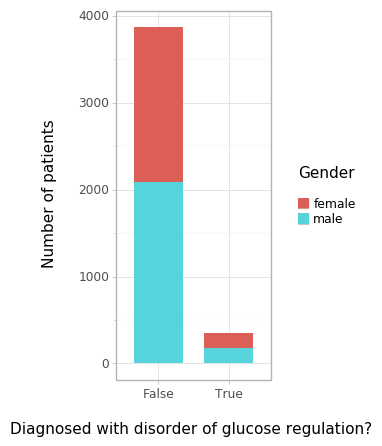

<ggplot: (-9223363254624629963)>

In [41]:
patients_with_membership = patients.join(membership, patients.id == membership.id, 'left_outer')

gender_counts = patients_with_membership.groupBy(patients_with_membership.inValueSet, patients.gender) \
                                        .agg(count(patients.id)) \
                                        .orderBy(patients_with_membership.inValueSet, patients.gender) \
                                        .toPandas()

ggplot(gender_counts) + aes(x='inValueSet', y='count(id)', fill='gender') \
                      + geom_bar(width=0.7, stat='identity') \
                      + scale_x_discrete(name='Diagnosed with disorder of glucose regulation?') \
                      + scale_y_continuous(name='Number of patients') \
                      + scale_fill_discrete(name='Gender') \
                      + theme(figure_size=(2,4.8))